# Evaluating Machine Learning Models for Gene Expression Analysis in AML and ALL Cancer Classification and Clustering


## Machine Learning Project
## Wina Munada - AIU221063

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import all the necessary library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [3]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set_theme(style="darkgrid")
np.random.seed(42)

In [4]:
warnings.filterwarnings("ignore")

In [5]:
le = LabelEncoder()

### Load data

In [6]:
train_data = pd.read_csv("/content/drive/MyDrive/gene-expression/data_set_ALL_AML_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/gene-expression/data_set_ALL_AML_independent.csv")
labels = pd.read_csv("/content/drive/MyDrive/gene-expression/actual.csv", index_col = 'patient')

In [7]:
train_data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [8]:
test_data.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


### Check NAs

In [9]:
print(train_data.isna().sum().sum())
print(test_data.isna().sum().sum())

0
0


## EDA and data preprocessing

It seems like **call** columns have "A" almost everywhere, so I will drop it.

In [10]:
cols_train = [col for col in train_data.columns if "call" in col]
cols_test = [col for col in test_data.columns if "call" in col]

train_data.drop(cols_train, axis=1, inplace=True)
test_data.drop(cols_test, axis=1, inplace=True)

Here we have features in rows and patients in cols, so we need to transpose data.

In [11]:
train_data = train_data.T
test_data = test_data.T

In [12]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [13]:
train_data.columns = test_data.iloc[1].values
train_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)
test_data.columns = test_data.iloc[1].values
test_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)

In [14]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [15]:
# Adding new column
train_data["patient"] = train_data.index.values
test_data["patient"] = test_data.index.values

In [16]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5


In [17]:
train_data = train_data.astype("int32")
test_data = test_data.astype("int32")

In [18]:
labels["cancer"] = le.fit_transform(labels["cancer"])
train_data = pd.merge(train_data, labels, on="patient")
test_data = pd.merge(test_data, labels, on="patient")

In [19]:
train_data["cancer"].value_counts()

cancer
0    27
1    11
Name: count, dtype: int64

In [20]:
test_data["cancer"].value_counts()

cancer
0    20
1    14
Name: count, dtype: int64

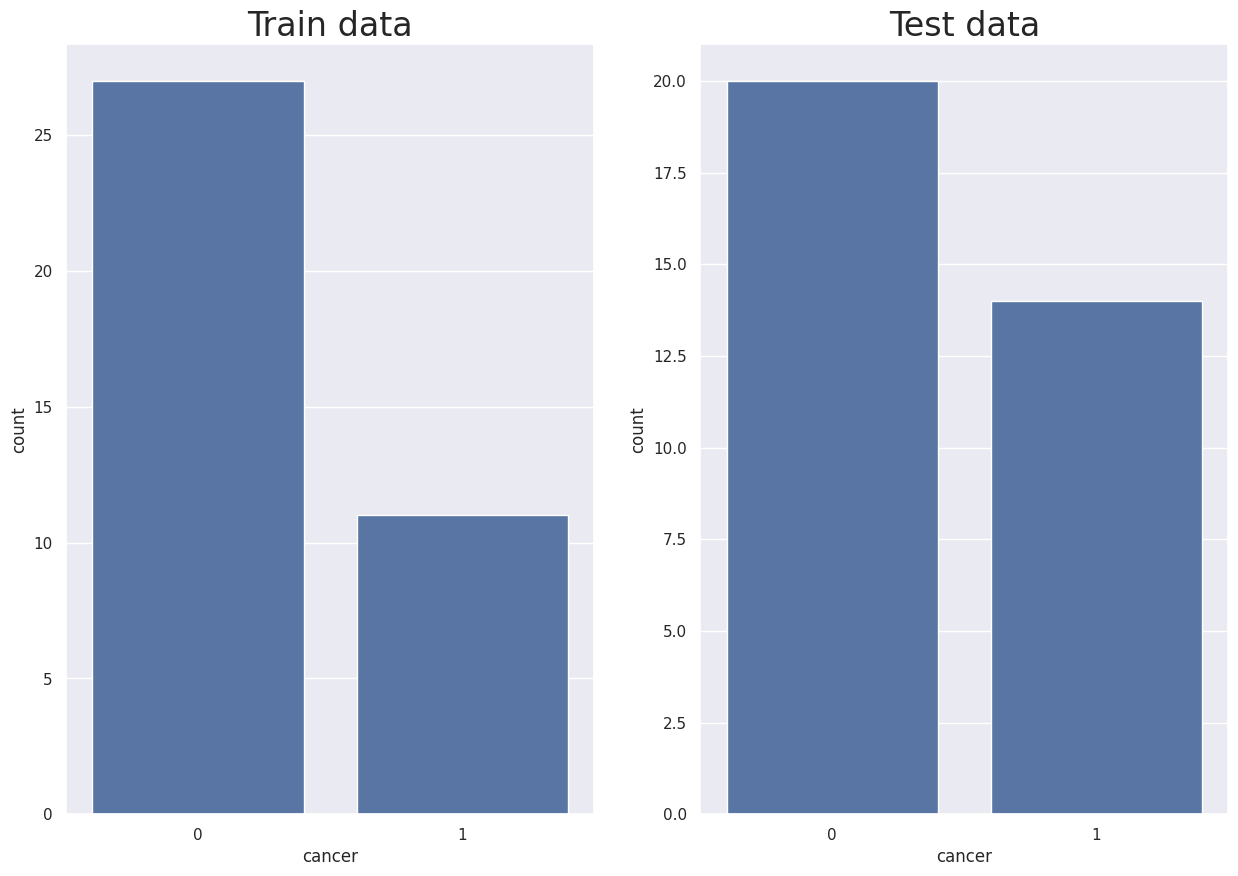

In [21]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
plt.show()

In test data we have $\frac{ALL}{AML}$ ratio about $\frac{20}{14}=1.43$ and in train $\frac{27}{11}=2.45$. Lets use upsampling to combat class imbalance. I think here we can add about 8 additional random samples of **AML** class.

In [22]:
upsampled_data = random.sample(train_data.query("cancer == 1")["patient"].index.to_list(), k=8, )

In [23]:
upsampled_data

[30, 37, 35, 27, 36, 32, 29, 31]

In [24]:
train_data_upsampled = pd.concat([train_data, train_data.iloc[upsampled_data, :]])

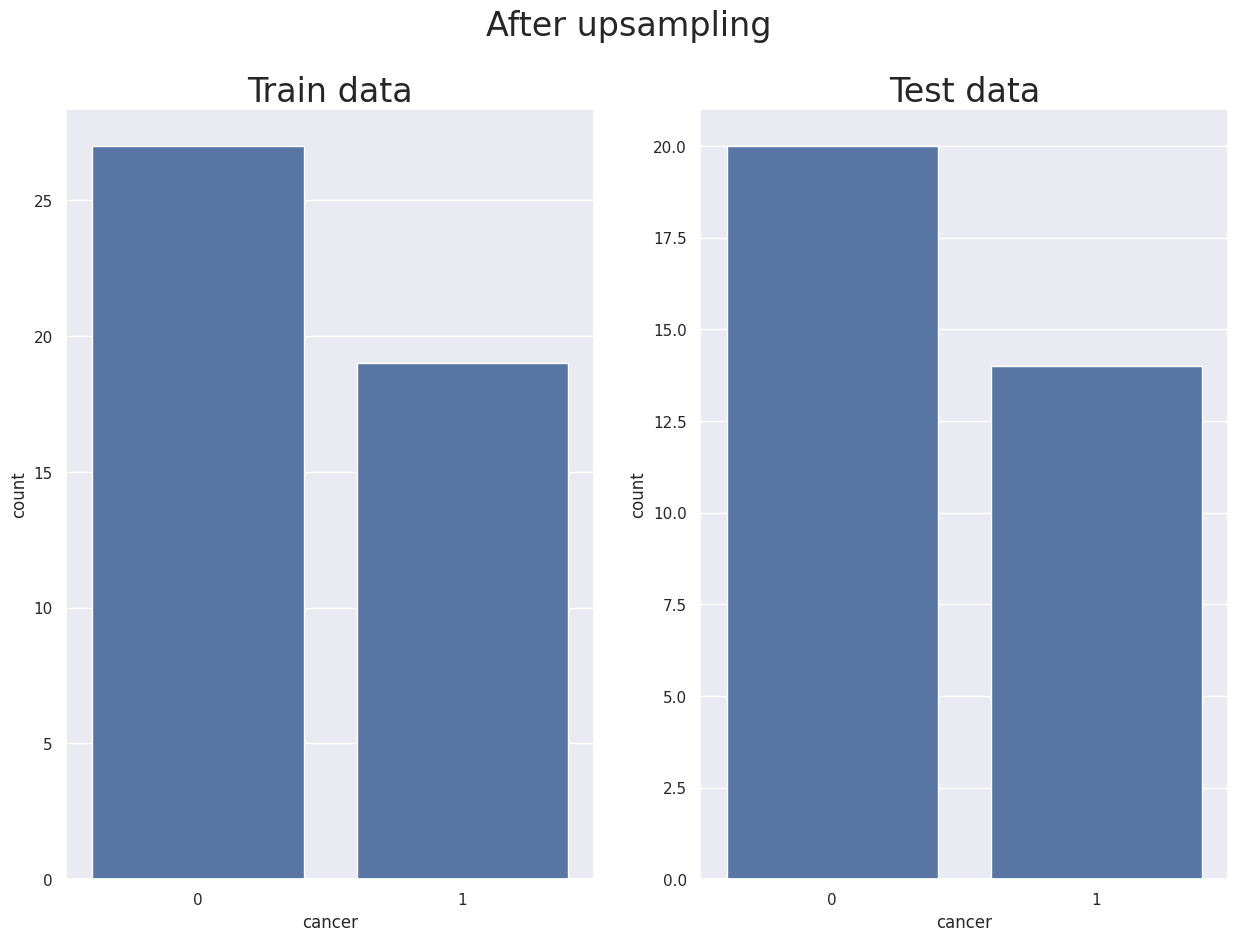

In [25]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data_upsampled, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
fig.suptitle("After upsampling", fontsize=24)
plt.show()

Scaling the data.

In [26]:
X_train = train_data_upsampled.drop(columns=["patient", "cancer"])
y_train = train_data_upsampled["cancer"]
X_test = test_data.drop(columns=["patient", "cancer"])
y_test = test_data["cancer"]

In [27]:
# Features scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [28]:
# PCA transformation to reduce the dimensionality
pca = PCA(n_components=2)
reduced_train = pca.fit_transform(X_train_scaled)
reduced_test = pca.transform(X_test_scaled)


27 features explain around 90% of the variance. From 7129 features to 27


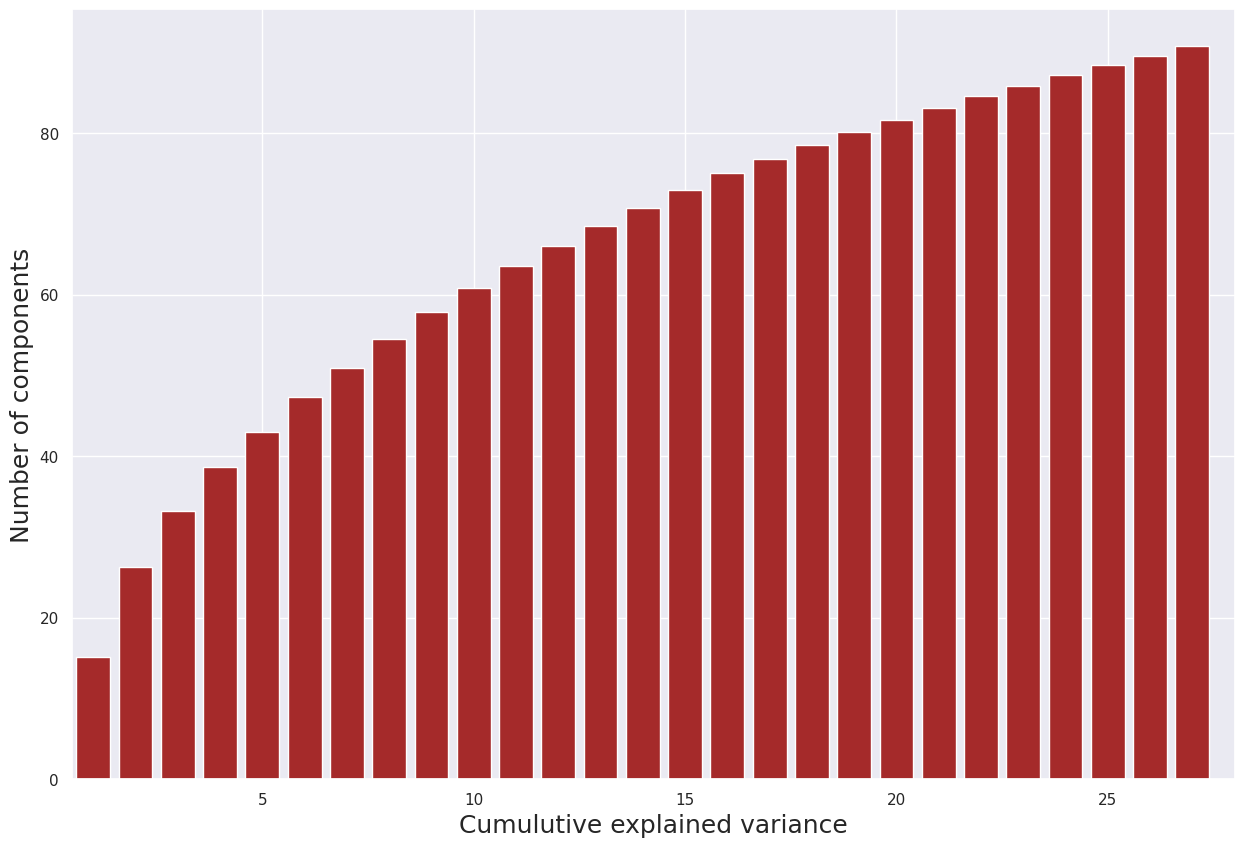

In [29]:
pca = PCA()
pca.fit_transform(X_train_scaled)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
print(k, " features explain around 90% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(1, k + 1), var_exp, color="brown")
plt.xlabel("Cumulutive explained variance", fontsize=18)
plt.ylabel("Number of components", fontsize=18)
plt.xlim((0.5, k + 1))
plt.show()

Here we can take approximately 27 PC for downstream analysis. May be we will use them later.

## Classification

I will start with **random forest**, esimate feature importance and then try to build ensemble using different classifiers.

## Random forest

In [ ]:
rf_params = {"bootstrap": [False, True],
             "n_estimators": [60, 70, 80, 90, 100],
             "max_features": [0.6, 0.65, 0.7, 0.75, 0.8],
             "min_samples_leaf": [8, 10, 12, 14],
             "min_samples_split": [3, 5, 7]
        }

rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring="f1")
rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_

In [ ]:
best_rf

RandomForestClassifier(max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=80)

Validation f1-score of RandomForest Classifier is 0.9285714285714286

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.93      0.93      0.93        14

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



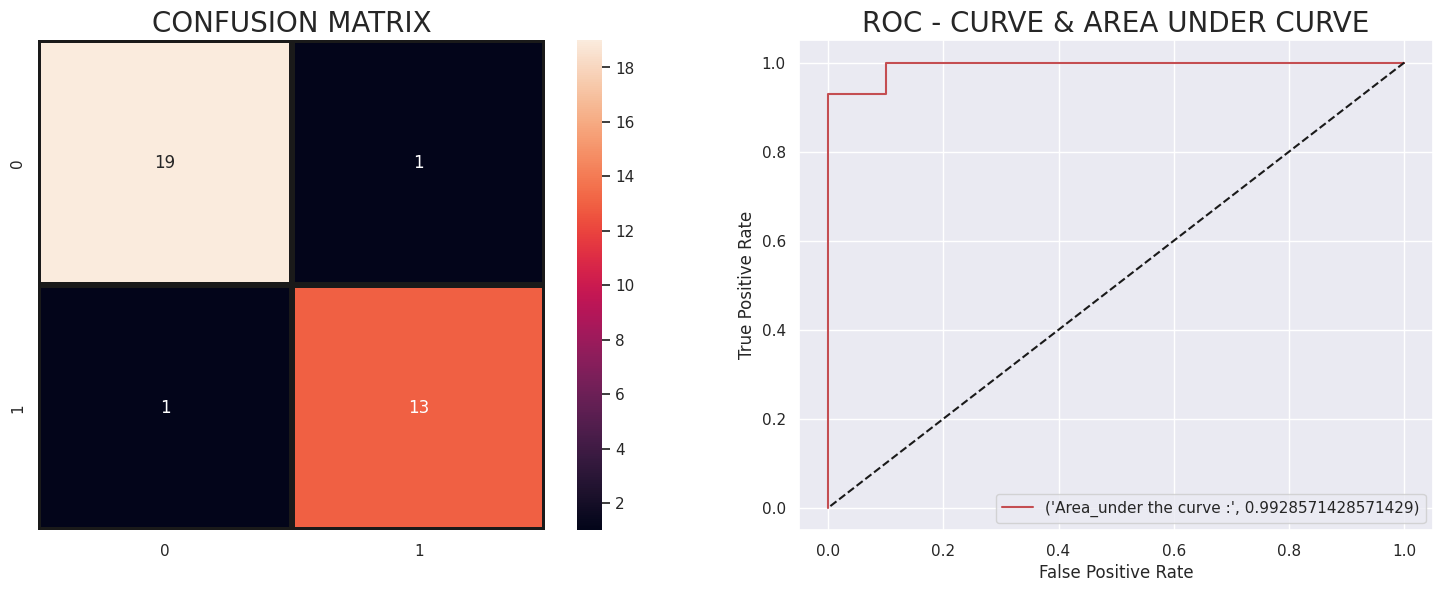

In [ ]:
rf_prediction = best_rf.predict(X_test_scaled)


f1_score = metrics.f1_score(y_test, rf_prediction)
print('Validation f1-score of RandomForest Classifier is', f1_score)
print ("\nClassification report :\n", metrics.classification_report(y_test, rf_prediction))

# Confusion matrix
plt.figure(figsize=(18, 14))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, rf_prediction), annot=True, fmt = "d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC curve
rf_predicted_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label = ("Area_under the curve :", metrics.auc(fpr, tpr)), color = "r")
plt.plot([1,0], [1,0], linestyle = "dashed", color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
plt.show()

In [ ]:
print(f"Quantity of features with 0 importance: {(best_rf.feature_importances_ == 0).sum()}")

Quantity of features with 0 importance: 7099


We have a lot of unimportant genes, so we can look only at non null features (with 0 importance).

In [ ]:
mask = (best_rf.feature_importances_ != 0)
importances = best_rf.feature_importances_[mask]
feature_names = train_data.columns.values[:7129][mask]

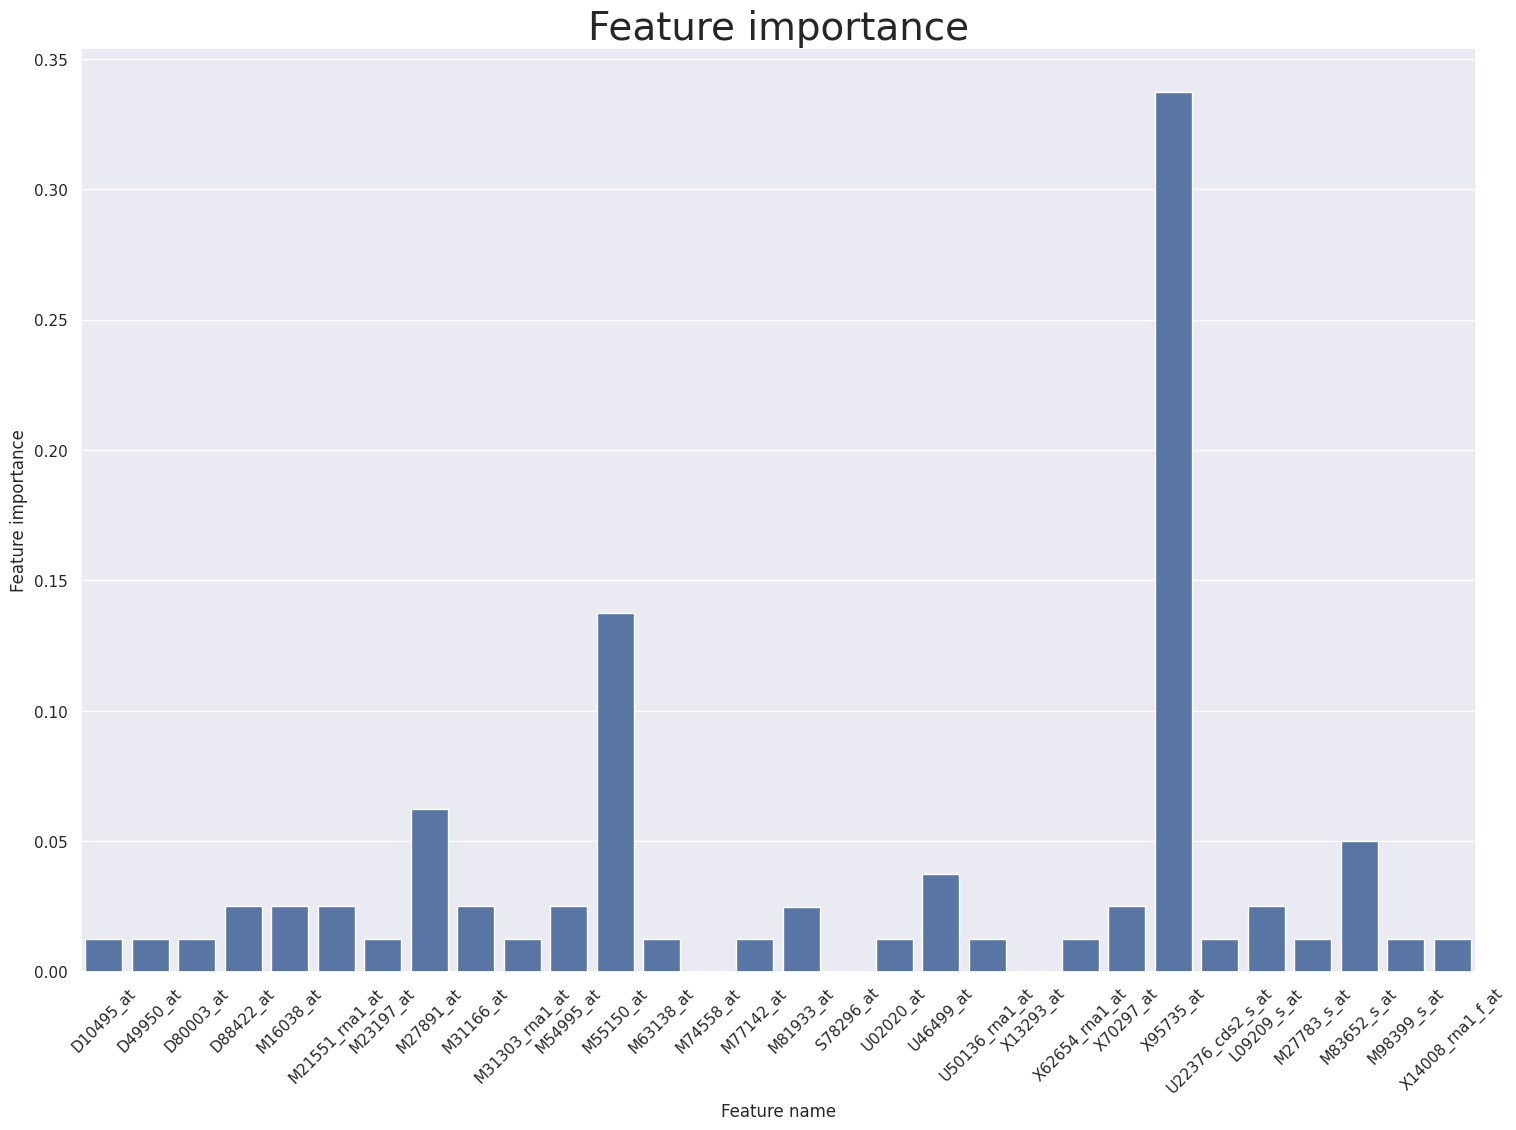

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
sns.barplot(x=feature_names, y=importances)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.title("Feature importance", fontsize=28)
ax.set_xticklabels(feature_names, rotation = 45)
plt.show()

As we can see there are also lots of features with pretty low importance (about e-5), but also we can admit 4 genes, wich have a big contribution in cancer classification. So genes **X95735**, **M55150**, and **M27891** contribute the most to the differences between **ALL** and **AML** cancer types in accordance with random forest classifier.

In [ ]:
print(metrics.accuracy_score(y_test, rf_prediction))

0.9411764705882353


It is a good model, but I am going to build ensemle based on different classifiers and hope it can show better performance.

## Ensemble

I want to build 5 different classifiers, evaluate some metrics (f1 score) and then try to create ensemble.

## KNN

In [ ]:
knn_params = {
    "n_neighbors": [i for i in range(1, 30, 5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["kd_tree"],
    "leaf_size": [1, 10, 20, 30],
    "p": [1, 2]
}
knn_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, verbose=1, scoring="f1")
knn_search.fit(X_train_scaled, y_train)
best_knn = knn_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
best_knn

KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=26, p=1,
                     weights='distance')

Validation F1-score of KNN Classifier is 0.4444444444444445

Classification report :
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        20
           1       1.00      0.29      0.44        14

    accuracy                           0.71        34
   macro avg       0.83      0.64      0.62        34
weighted avg       0.80      0.71      0.65        34



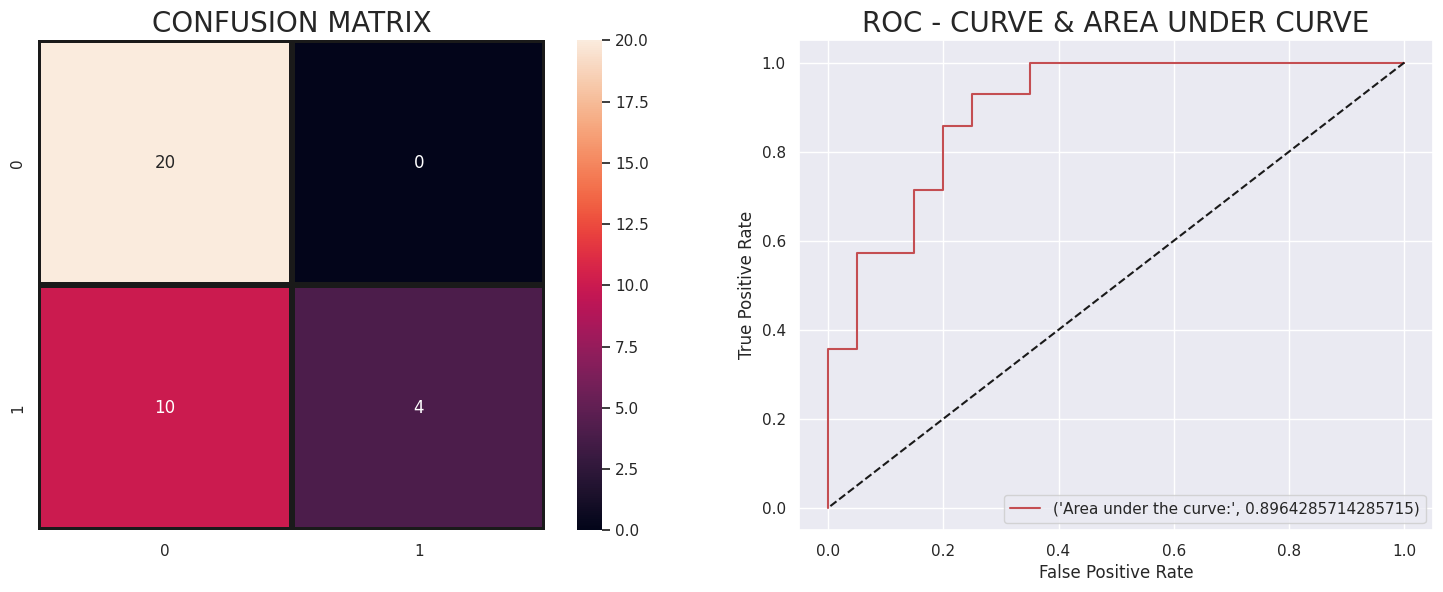

In [ ]:
# KNN prediction
knn_prediction = best_knn.predict(X_test_scaled)

# F1 Score
knn_f1_score = metrics.f1_score(y_test, knn_prediction)
print('Validation F1-score of KNN Classifier is', knn_f1_score)
print("\nClassification report :\n", metrics.classification_report(y_test, knn_prediction))

# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, knn_prediction), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
knn_predicted_probs = best_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", metrics.auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()


best_knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=6, p=1,
                     weights='distance')

## Logistic Regression

In [ ]:
lr_params = {"C": [1e-03, 1e-2, 1e-1, 1, 10],
      "penalty": ["l1", "l2"]}
log_refr_search = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_params, scoring="f1")
log_refr_search.fit(X_train_scaled, y_train)
best_lr = log_refr_search.best_estimator_

In [ ]:
best_lr

LogisticRegression(C=0.001)

best_lr = LogisticRegression(C=0.001)

Validation F1-score of Logistic Regression Classifier is 0.7272727272727273

Classification report :
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.57      0.73        14

    accuracy                           0.82        34
   macro avg       0.88      0.79      0.80        34
weighted avg       0.86      0.82      0.81        34



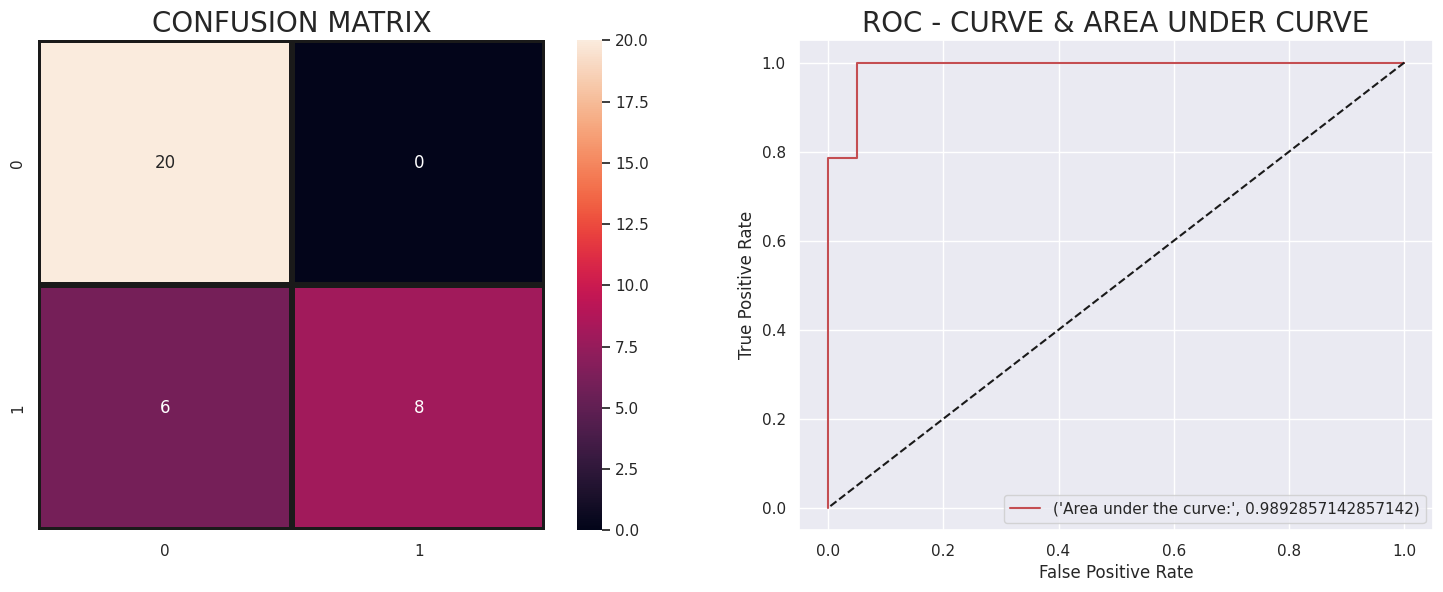

In [ ]:
# Logistic Regression prediction
lr_prediction = best_lr.predict(X_test_scaled)

# F1 Score
lr_f1_score = metrics.f1_score(y_test, lr_prediction)
print('Validation F1-score of Logistic Regression Classifier is', lr_f1_score)
print("\nClassification report :\n", metrics.classification_report(y_test, lr_prediction))

# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, lr_prediction), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
lr_predicted_probs = best_lr.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", metrics.auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()

## Decision Tree

In [ ]:
dt_params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth':[3,4,5,6,7,8]}
dst_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=dt_params, verbose=1, cv=3, scoring="f1")
dst_search.fit(X_train_scaled, y_train)
best_dt = dst_search.best_estimator_

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


In [ ]:
best_dt

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=2, random_state=42)

Validation F1-score of Decision Tree Classifier is 0.896551724137931

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



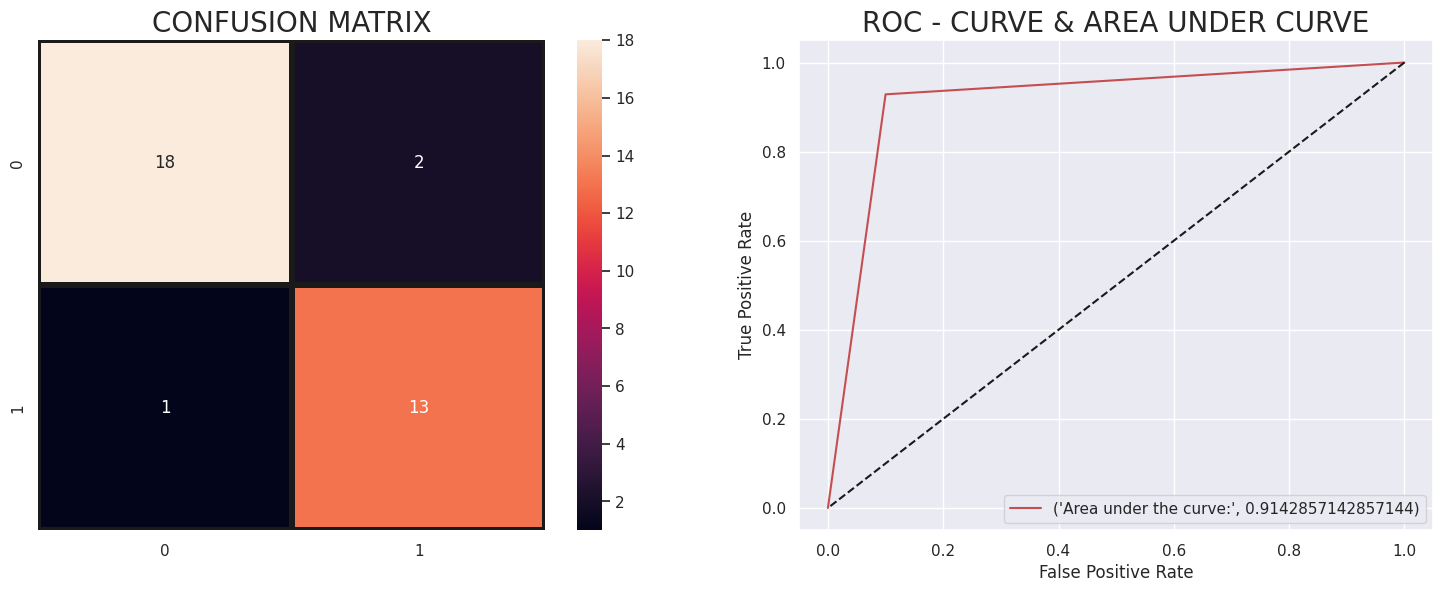

In [ ]:
# Decision Tree prediction
dt_prediction = best_dt.predict(X_test_scaled)

# F1 Score
dt_f1_score = metrics.f1_score(y_test, dt_prediction)
print('Validation F1-score of Decision Tree Classifier is', dt_f1_score)
print("\nClassification report :\n", metrics.classification_report(y_test, dt_prediction))

# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, dt_prediction), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
dt_predicted_probs = best_dt.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", metrics.auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()

best_dt = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=2, random_state=42)

In [ ]:
print(f"Quantity of features with 0 importance: {(best_dt.feature_importances_ == 0).sum()}")

mask_dt = (best_dt.feature_importances_ != 0)
importances_dt = best_dt.feature_importances_[mask_dt]
feature_names_dt = train_data.columns.values[:7129][mask_dt]

Quantity of features with 0 importance: 7128


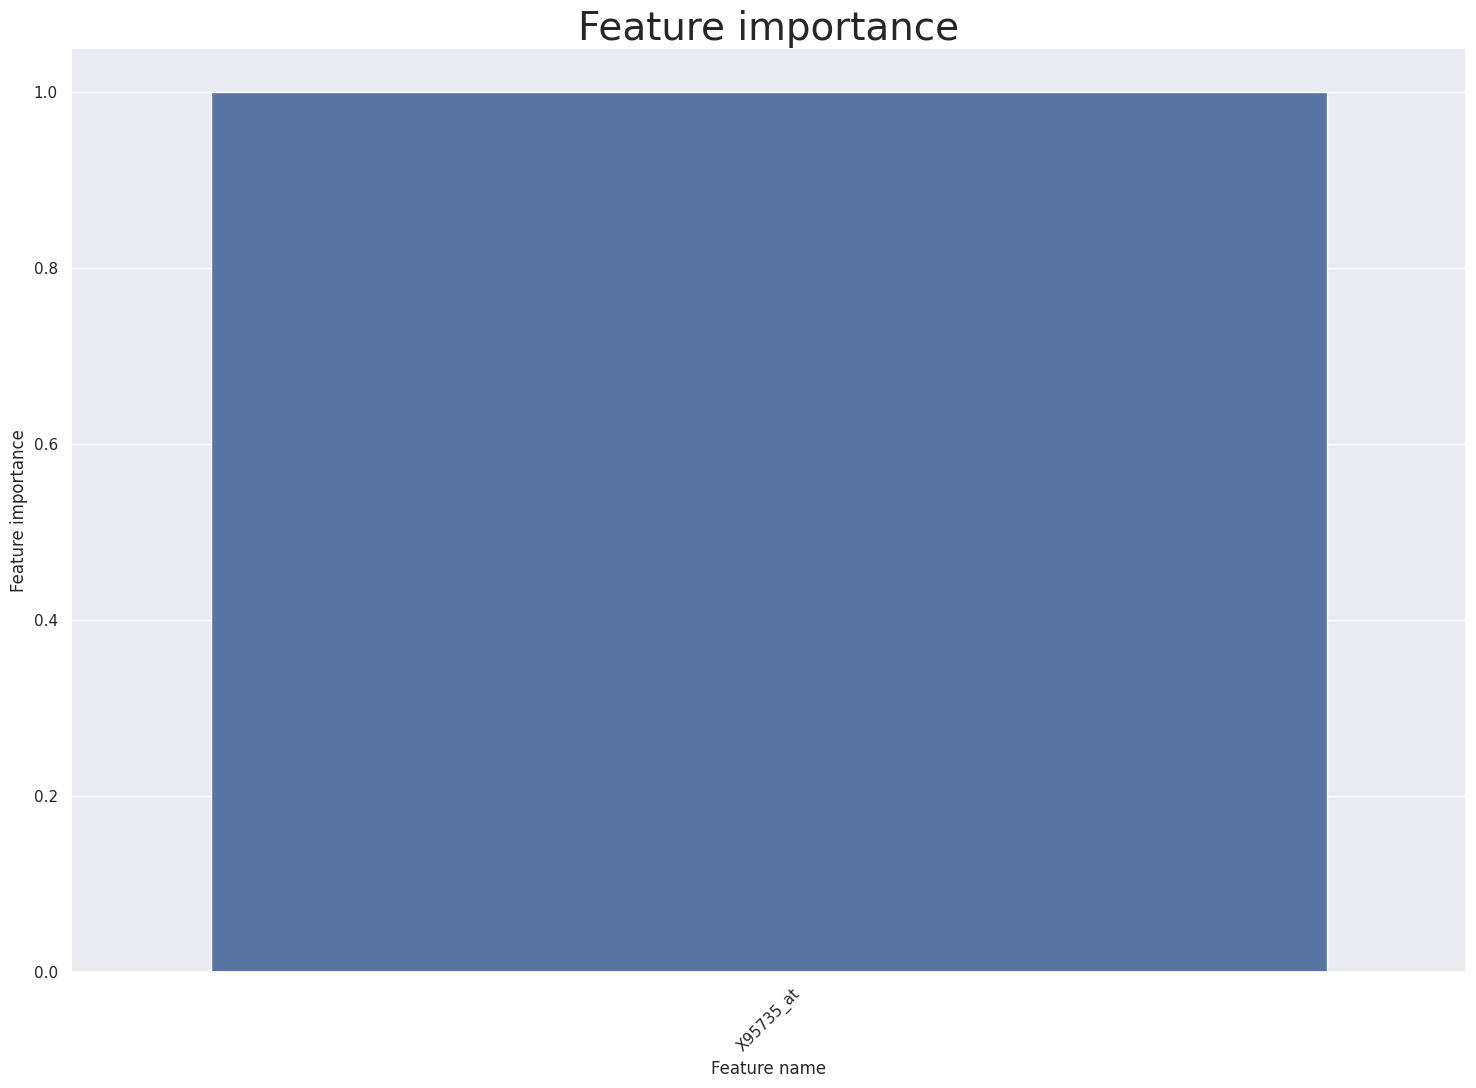

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
sns.barplot(x=feature_names_dt, y=importances_dt)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.title("Feature importance", fontsize=28)
ax.set_xticklabels(feature_names_dt, rotation = 45)
plt.show()

## SVC

In [ ]:
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
svc_search = GridSearchCV(SVC(probability=True), param_grid=svc_params, n_jobs=-1, verbose=1, scoring="f1")
svc_search.fit(X_train_scaled, y_train)
best_svc = svc_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
best_svc

SVC(C=1, kernel='linear', probability=True)

Validation F1-score of SVC Classifier is 0.782608695652174

Classification report :
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.64      0.78        14

    accuracy                           0.85        34
   macro avg       0.90      0.82      0.84        34
weighted avg       0.88      0.85      0.85        34



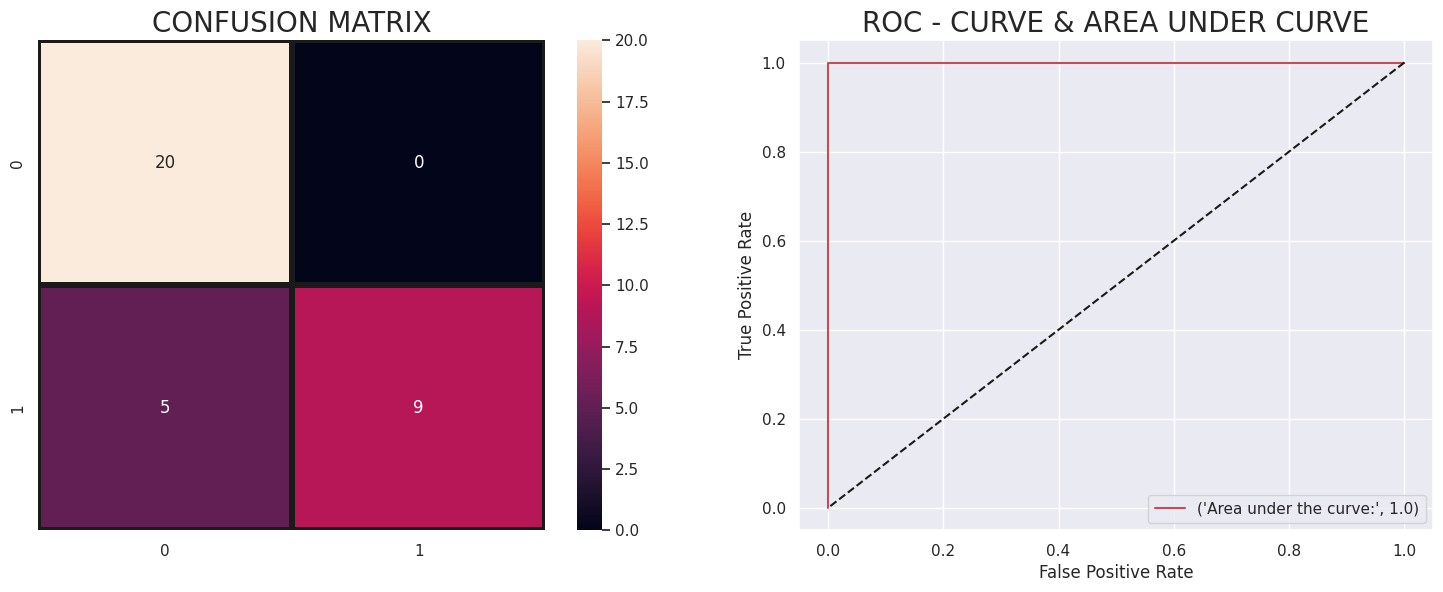

In [ ]:
# SVC prediction
svc_prediction = best_svc.predict(X_test_scaled)

# F1 Score
svc_f1_score = metrics.f1_score(y_test, svc_prediction)
print('Validation F1-score of SVC Classifier is', svc_f1_score)
print("\nClassification report :\n", metrics.classification_report(y_test, svc_prediction))

# Confusion Matrix
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, svc_prediction), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
svc_predicted_probs = best_svc.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, svc_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve:", metrics.auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
plt.show()


best_svc = SVC(C=1, kernel='linear', probability=True)

## Builing an ensemble

So now we have 4 different classifiers, some of them are good and the others are not and I want to use all of them to classify two cancer types. I will weigh my classifiers based on f1-score such that I will calculate mean f1-score and then divide f1-score of each model by mean, so the best estimator will have the higher weight.

In [ ]:
rf_f1_score = metrics.f1_score(y_test, best_rf.predict(X_test_scaled))
knn_f1_score = metrics.f1_score(y_test, best_knn.predict(X_test_scaled))
lr_f1_score = metrics.f1_score(y_test, best_lr.predict(X_test_scaled))
dt_f1_score = metrics.f1_score(y_test, best_dt.predict(X_test_scaled))
svc_f1_score = metrics.f1_score(y_test, best_svc.predict(X_test_scaled))
kmeans_f1_score = f1_score(y_test, y_pred_kmeans)

In [ ]:
# Calculate metrics for each model

svc_recall = metrics.recall_score(y_test, svc_prediction)
svc_accuracy = metrics.accuracy_score(y_test, svc_prediction)

knn_recall = metrics.recall_score(y_test, knn_prediction)
knn_accuracy = metrics.accuracy_score(y_test, knn_prediction)

lr_recall = metrics.recall_score(y_test, lr_prediction)
lr_accuracy = metrics.accuracy_score(y_test, lr_prediction)

dt_recall = metrics.recall_score(y_test, dt_prediction)
dt_accuracy = metrics.accuracy_score(y_test, dt_prediction)

rf_recall = metrics.recall_score(y_test, rf_prediction)
rf_accuracy = metrics.accuracy_score(y_test, rf_prediction)

kmeans_recall = recall_score(y_test, y_pred_kmeans)
kmeans_accuracy = accuracy_score(y_test, y_pred_kmeans)

# Create a DataFrame with all metrics
model_metrics = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Means'],
    'F1-Score': [svc_f1_score, knn_f1_score, lr_f1_score, dt_f1_score, rf_f1_score, kmeans_f1_score],
    'Recall': [svc_recall, knn_recall, lr_recall, dt_recall, rf_recall, kmeans_recall],
    'Accuracy': [svc_accuracy, knn_accuracy, lr_accuracy, dt_accuracy, rf_accuracy, kmeans_accuracy],
})

# Sort by F1-Score
sorted_model_metrics = model_metrics.sort_values(by='F1-Score', ascending=False)

print(sorted_model_metrics)


                     Model  F1-Score    Recall  Accuracy
4            Random Forest  0.928571  0.928571  0.941176
3            Decision Tree  0.896552  0.928571  0.911765
0  Support Vector Machines  0.782609  0.642857  0.852941
2      Logistic Regression  0.727273  0.571429  0.823529
5                  K-Means  0.615385  0.571429  0.705882
1                      KNN  0.444444  0.285714  0.705882


In [ ]:
mean_f1_score = np.mean([rf_f1_score, knn_f1_score, lr_f1_score, dt_f1_score, svc_f1_score])
weight_rf = rf_f1_score / mean_f1_score
weight_knn = knn_f1_score / mean_f1_score
weight_lr = lr_f1_score / mean_f1_score
weight_dt = dt_f1_score / mean_f1_score
weight_svc = svc_f1_score / mean_f1_score

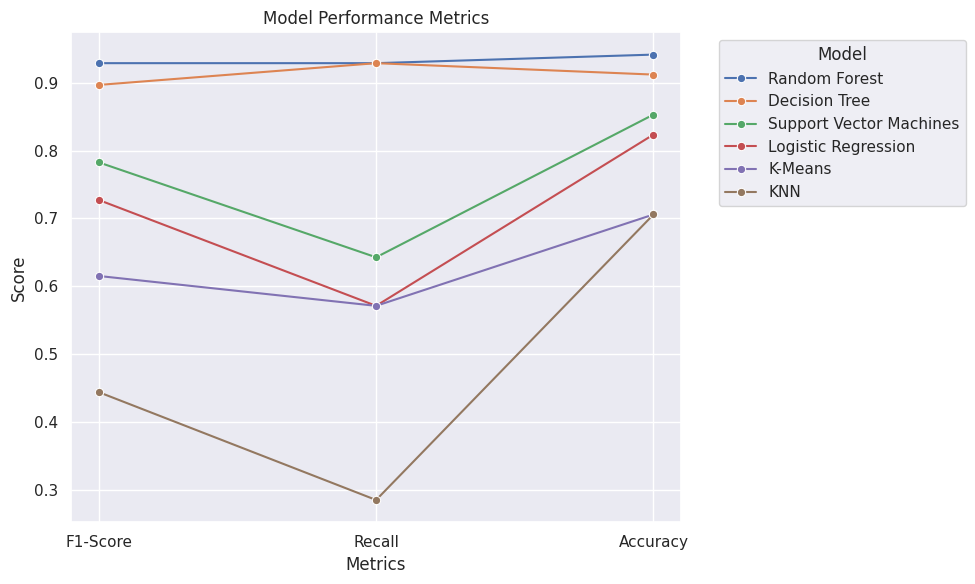

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the metrics have already been calculated as shown in the previous code
# Create a DataFrame with all metrics
model_metrics = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Means'],
    'F1-Score': [svc_f1_score, knn_f1_score, lr_f1_score, dt_f1_score, rf_f1_score, kmeans_f1_score],
    'Recall': [svc_recall, knn_recall, lr_recall, dt_recall, rf_recall, kmeans_recall],
    'Accuracy': [svc_accuracy, knn_accuracy, lr_accuracy, dt_accuracy, rf_accuracy, kmeans_accuracy],
})

# Sort by F1-Score
sorted_model_metrics = model_metrics.sort_values(by='F1-Score', ascending=False)

# Melt the DataFrame for seaborn
melted_metrics = pd.melt(sorted_model_metrics, id_vars=['Model'], var_name='Metrics', value_name='Score')

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")

sns.lineplot(data=melted_metrics, x='Metrics', y='Score', hue='Model', marker='o')

plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
model_weights = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest'],

    'weight': [weight_svc, weight_knn, weight_lr, weight_dt,
              weight_rf]})
model_weights.sort_values(by='weight', ascending=False)

,Model,weight
4,Random Forest,1.228448
3,Decision Tree,1.186088
0,Support Vector Machines,1.035348
2,Logistic Regression,0.962141
1,KNN,0.587975


In [ ]:
ensemble = VotingClassifier(estimators=[("rf", best_rf), ("knn", best_knn), ("lr", best_lr), ("dt", best_dt), ("svc", best_svc)],
                                        voting="soft", weights=[weight_rf, weight_knn, weight_lr, weight_dt, weight_svc])

In [ ]:
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features=0.6,
                                                     min_samples_leaf=8,
                                                     min_samples_split=3,
                                                     n_estimators=80)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=1, n_neighbors=26,
                                                   p=1, weights='distance')),
                             ('lr', LogisticRegression(C=0.001)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_leaf_nodes=2,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=1, kernel='linear', probability=True))],
                 voting='soft',
                 weights=[1.2284481463280745, 0.5879751811484801,
                          0.9621412055156947, 1.1860878654202098,
                          1.0353476015875411])

Validation f1-score of Ensemble Classifier is 0.962962962962963

Classification report :
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.93      0.96        14

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34



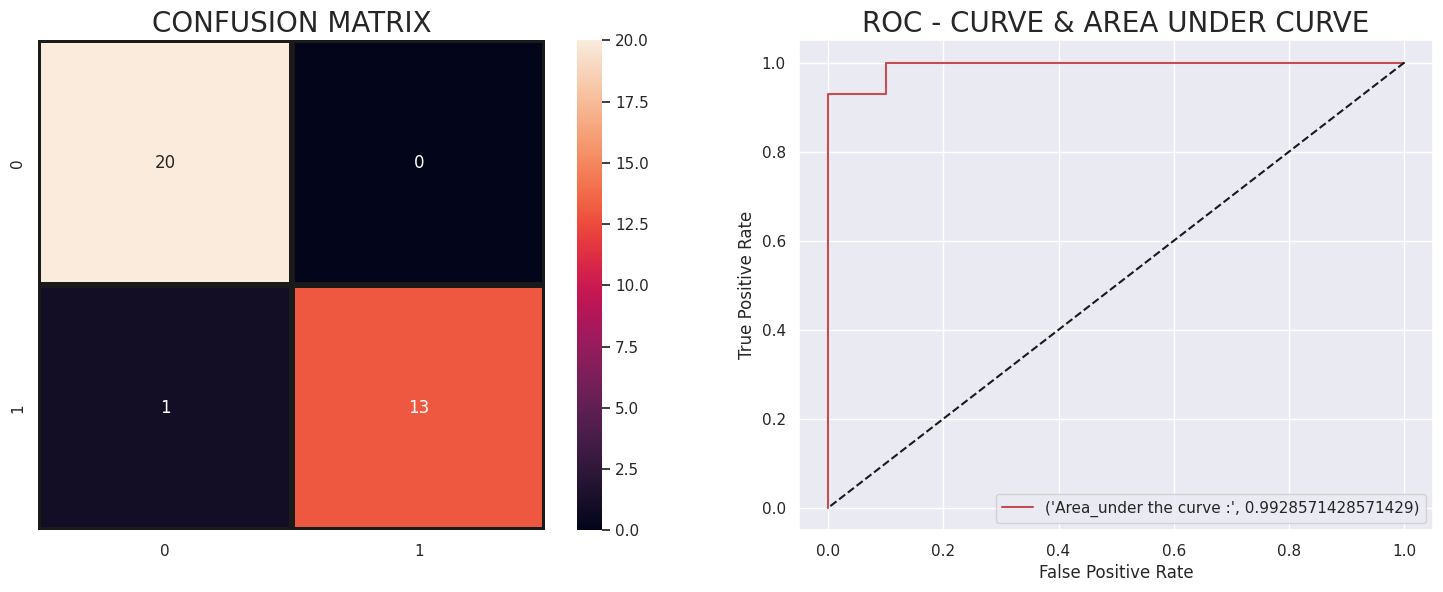

In [ ]:
ens_prediction = ensemble.predict(X_test_scaled)
f1_score = metrics.f1_score(y_test, ens_prediction)
print('Validation f1-score of Ensemble Classifier is', f1_score)
print ("\nClassification report :\n", metrics.classification_report(y_test, ens_prediction))

# Confusion matrix
plt.figure(figsize=(18, 14))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, ens_prediction), annot=True, fmt = "d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC curve
ens_predicted_probs = ensemble.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, ens_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label = ("Area_under the curve :", metrics.auc(fpr, tpr)), color = "r")
plt.plot([1,0], [1,0], linestyle = "dashed", color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
plt.show()

As we can see Ensemble have shown the best performance